In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
# random.seed(0)

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [3]:
imheight = 28
imwidth = 28
channels = 1
# ALPHA = 0.2
ALPHA=0.05

In [4]:
# shared Layer 
shared_Conv1= Conv2D(32, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [5]:
def create_embNet():
    some_input = Input(shape=(imwidth, imheight, channels))
    conv1 = shared_Conv1(some_input)
    pool1 = shared_MP1(conv1)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    flatten = Flatten()(pool2)
    dense_layer = Dense(10, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return Model(inputs=[some_input], outputs=norm_layer)

In [6]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [7]:
# for embedding
embNet_a = create_embNet()
embNet_p = create_embNet()
embNet_n = create_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

In [8]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

## -----------------------------------------------------------------------------------------
## make triplet with mnist dataset

In [10]:
from keras.datasets import mnist
from keras.utils import np_utils

# load mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Reshape mnist data from (60000,28,28) to (60000,28,28,1)

In [11]:
if K.image_data_format() == 'channels_first': # Theano backend
    X_train = X_train.reshape(X_train.shape[0], 1, imwidth, imheight)
    X_test = X_test.reshape(X_test.shape[0], 1, imwidth, imheight)
    input_shape = (1, imwidth, imheight)
else:                                         # Tensorflow backend
    X_train = X_train.reshape(X_train.shape[0], imwidth, imheight, 1)
    X_test = X_test.reshape(X_test.shape[0], imwidth, imheight, 1)
    input_shape = (imwidth, imheight, 1)

In [12]:
# # get indexes of y = 0
# np.where(y_train == 0)

In [13]:
# print(X_train[np.where(y_train == 0)].shape)
# print(X_train[np.where(y_train == 0)][0].shape)

In [14]:
# 謎のエラー
# plt.imshow(X_train[np.where(y_train == 0)][0].reshape(imwidth,imheight))

In [15]:
# X_train0 = X_train[np.where(y_train == 0)]
# X_train1 = X_train[np.where(y_train == 1)]
# X_train2 = X_train[np.where(y_train == 2)]
# X_train3 = X_train[np.where(y_train == 3)]
# X_train4 = X_train[np.where(y_train == 4)]
# X_train5 = X_train[np.where(y_train == 5)]
# X_train6 = X_train[np.where(y_train == 6)]
# X_train7 = X_train[np.where(y_train == 7)]
# X_train8 = X_train[np.where(y_train == 8)]
# X_train9 = X_train[np.where(y_train == 9)]

In [16]:
# # get anchor and positive image　
# pair = np.random.randint(0,len(X_train1),2)
# anchor = X_train1[pair[0]]
# positive = X_train1[pair[1]]

# nega_idx = np.random.randint(len(X_train2))
# negative = X_train2[nega_idx]

In [17]:
# triplet = [anchor, positive, negative]
# # method for visualization
# def plot_triplet(triplet):
#     title = ['anchor','positive','negative']
#     for i,t in enumerate(triplet):
#         plt.subplot(1,3,i+1)
#         plt.imshow(triplet[i].reshape(imwidth, imheight))
#         plt.title('{}'.format(title[i]))
#     plt.show()
    
# plot_triplet(triplet)

## Create Triplets

In [18]:
# triplet_num = 2000
# triplets = []
# mnist_data = [X_train0,X_train1,X_train2,X_train3,X_train4,X_train5,X_train6,X_train7,X_train8,X_train9]
# for i in range(len(mnist_data)): # roop for 0~!
#     # set the files of anchor and positive images
#     pres_mnist = mnist_data[i]
#     for iteration in range(triplet_num):
#         # set the number of negative images
#         j = random.choice([num for num in range(len(mnist_data)) if num not in [i]])
#         nega_files = mnist_data[j]

#         # get anchor and positive images as numpy array
#         pair = np.random.randint(0,len(pres_mnist),2)
#         anchor = pres_mnist[pair[0]]
#         positive = pres_mnist[pair[1]]
        
#         # get negative images as numpy array
#         nega_idx = np.random.randint(len(nega_files))
#         negative = nega_files[nega_idx]

#         # make triplet
#         triplet = [anchor, positive, negative]
        
#         # (optional)visualization
#         # plot_triplet(triplet)
        
#         # append with normalization (0,1)
#         triplets.append([anchor/255., positive/255., negative/255.])
        
# # save triplets as numpy array
# triplets = np.array(triplets)
# print('save file')
# np.save('./mnist_model/mnisTriplets.npy',triplets)

In [19]:
# triplets = np.load('./mnist_model/mnisTriplets.npy')
# print(triplets.shape)

In [20]:
# type(triplets)

In [21]:
# triplets[:,2].shape

In [22]:
triplets = np.load('./mnist_model/mnisTriplets.npy')

# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, batch_size=100) # using batch_size is better
tripletNet.save('./mnist_model/mnisTriplet.h5')

# save partial Network 
embNet_a.save('./mnist_model/mnist_embNet_a2.h5')
embNet_p.save('./mnist_model/mnist_embNet_p2.h5')
embNet_n.save('./mnist_model/mnist_embNet_n2.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  after removing the cwd from sys.path.


Epoch 1/10
20000/20000 [==============================] - 4s 201us/step - loss: 0.2618
Epoch 2/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.0000e+00
Epoch 3/10
20000/20000 [==============================] - 2s 122us/step - loss: 0.0000e+00
Epoch 4/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.0000e+00
Epoch 5/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.0000e+00
Epoch 6/10
20000/20000 [==============================] - 2s 120us/step - loss: 0.0000e+00
Epoch 7/10
20000/20000 [==============================] - 2s 120us/step - loss: 0.0000e+00
Epoch 8/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.0000e+00
Epoch 9/10
20000/20000 [==============================] - 2s 122us/step - loss: 0.0000e+00
Epoch 10/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.0000e+00


In [23]:
from keras.models import load_model
embNet = load_model('./mnist_model/mnist_embNet_a2.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
emb_vecs = np.zeros((len(X_test),10))
# plt.subplots_adjust(wspace=2, hspace=2)
# plt.figure(figsize=(15,15))
for i,x in enumerate(X_test):
#     plt.subplot(1,len(X_test),i+1)
#     plt.imshow(x.reshape(imheight,imwidth))
    x = (x/255.).astype(np.float32)
    emb_vecs[i] = embNet.predict(np.expand_dims(x,axis=0))[0] # need [0] because of expanding dimension -> [[]]
# plt.show()

In [25]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

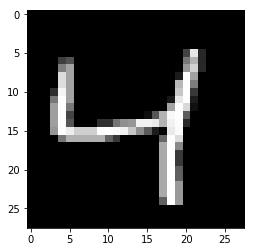

In [26]:
i = 2
test = embNet.predict(np.expand_dims((X_train[i] / 255.).astype(np.float32),axis=0))[0]
plt.imshow(X_train[i].reshape(imwidth,imheight),cmap='gray')

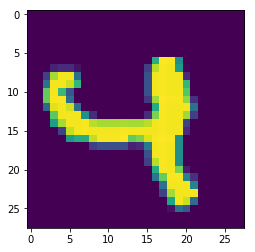

In [27]:
similarities = np.zeros(len(emb_vecs))
for i,emb_vec in enumerate(emb_vecs):
    similarities[i] = distance(test,emb_vec)
min_idx = np.argmin(similarities)
nearest = X_test[min_idx]

plt.imshow(nearest.reshape(imwidth,imheight))

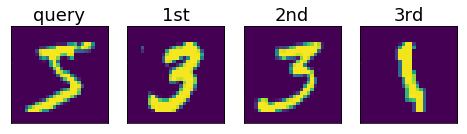

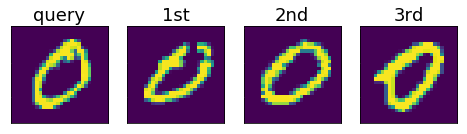

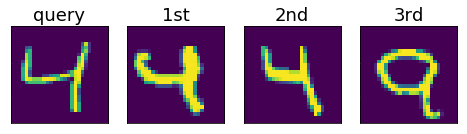

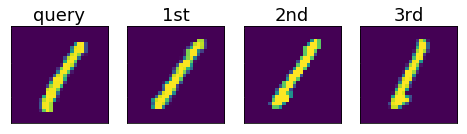

In [66]:
similarities=np.zeros(len(emb_vecs))
for i in range(4):
    # show query
    plt.figure(figsize=(8,8))
    plt.subplot(1,4,1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    test = embNet.predict(np.expand_dims((X_train[i] / 255.).astype(np.float32),axis=0))[0]
    plt.title('query',fontsize=18)
    plt.imshow(X_train[i].reshape(imwidth,imheight))

    # calc order
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec)
    idxs = similarities.argsort() #ascending order b.c. smaller is better
    
    # show nearest
    plt.subplot(1,4,2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    nearest = X_test[idxs[0]]
    plt.title('1st',fontsize=18)
    plt.imshow(nearest.reshape(imwidth,imheight))  
    
    # show 2nd nearest
    plt.subplot(1,4,3)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    nearest = X_test[idxs[1]]
    plt.title('2nd',fontsize=18)
    plt.imshow(nearest.reshape(imwidth,imheight))  
    
    # show 3rd nearest
    plt.subplot(1,4,4)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    nearest = X_test[idxs[2]]
    plt.title('3rd',fontsize=18)
    plt.imshow(nearest.reshape(imwidth,imheight))  
    
plt.savefig('sup/mnist_img/{}mnist_retrieval.png'.format(i),bbox_inches='tight')
plt.show()

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(emb_vecs)
transformed = pca.fit_transform(emb_vecs)

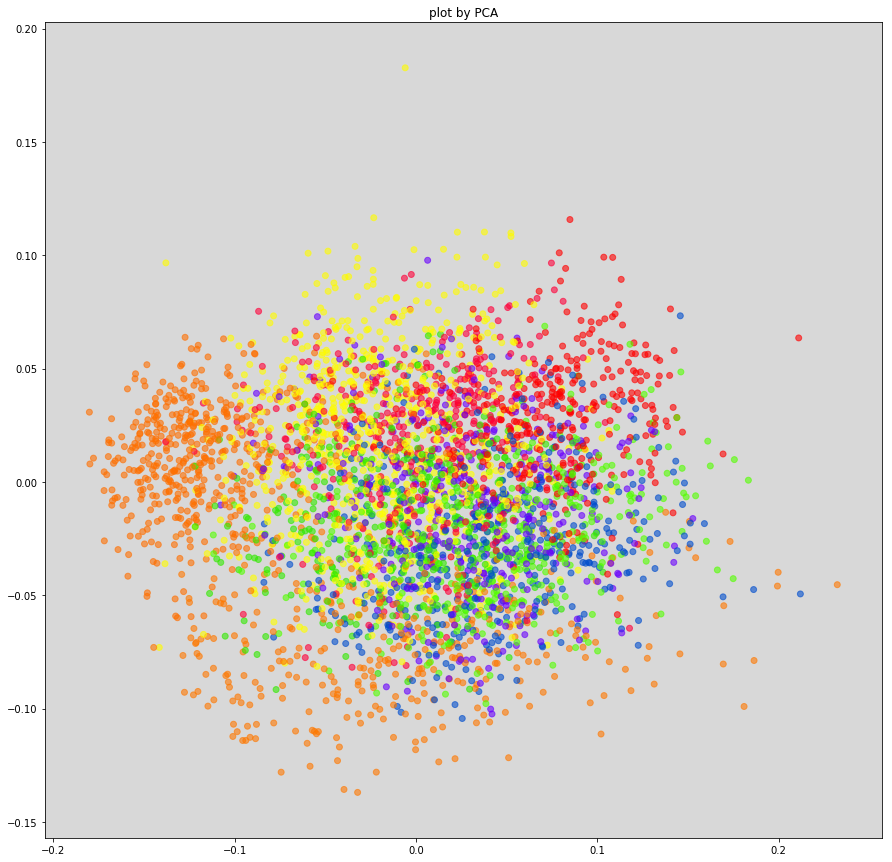

In [30]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('gray')
ax.patch.set_alpha(0.3)
plt.scatter(transformed[:4000, 0], transformed[:4000, 1],c=y_test[:4000],cmap='prism',alpha=0.6)
plt.title('plot by PCA')
plt.savefig('sup/PCA_plot.png',bbox_inches='tight')
plt.show()

In [31]:
emb_vecs[:10]

array([[ 0.25172201,  0.47815809,  0.31412959,  0.        ,  0.        ,
         0.        ,  0.53415465,  0.        ,  0.        ,  0.5692119 ],
       [ 0.44450945,  0.50133592,  0.31168884,  0.        ,  0.        ,
         0.        ,  0.42680207,  0.        ,  0.        ,  0.52130955],
       [ 0.32351714,  0.50262982,  0.25327879,  0.        ,  0.        ,
         0.03756598,  0.46213469,  0.        ,  0.        ,  0.6029678 ],
       [ 0.41733763,  0.46218088,  0.38797414,  0.        ,  0.        ,
         0.        ,  0.46888784,  0.        ,  0.        ,  0.49177068],
       [ 0.36553922,  0.49882123,  0.39346316,  0.        ,  0.        ,
         0.        ,  0.47868675,  0.        ,  0.        ,  0.48332623],
       [ 0.31474879,  0.48651242,  0.28099898,  0.        ,  0.        ,
         0.        ,  0.4854449 ,  0.        ,  0.        ,  0.59128809],
       [ 0.34751871,  0.47904617,  0.35093546,  0.        ,  0.        ,
         0.        ,  0.55047321,  0.        

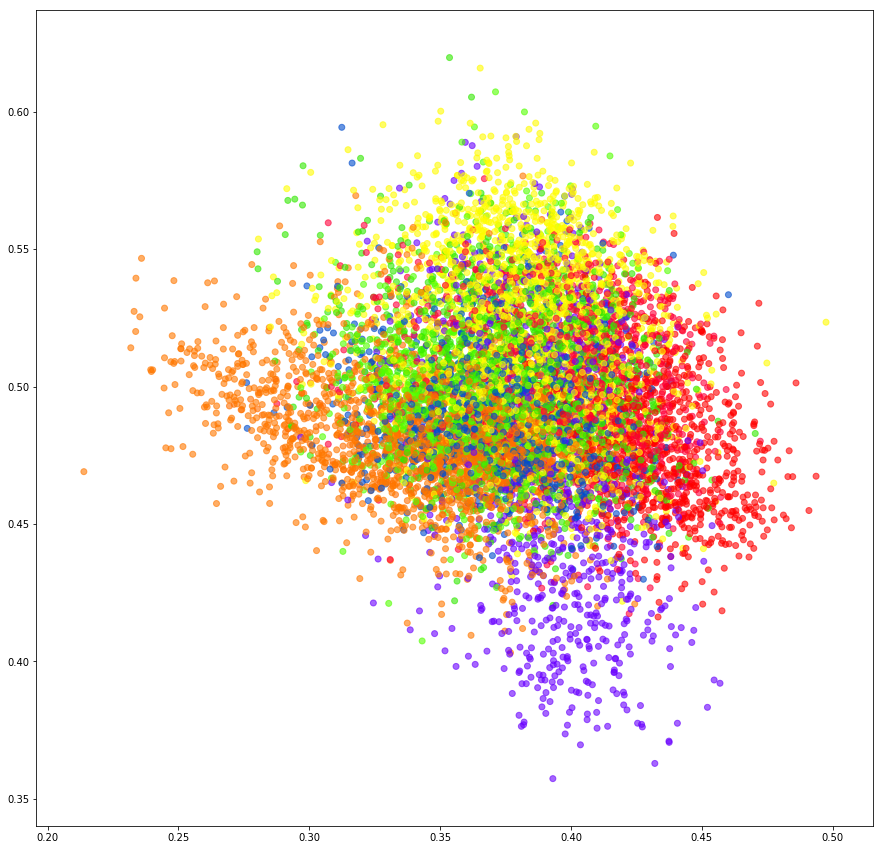

In [32]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
xlim = [emb_vecs[:,0].min(), emb_vecs[:,0].max()]
ylim = [emb_vecs[:,1].min(), emb_vecs[:,1].max()]
plt.scatter(emb_vecs[:,0],emb_vecs[:,1],c=y_test,cmap='prism',alpha=0.6)

In [33]:
emb_vecs.shape

(10000, 10)

In [34]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/inouelab/.conda/envs/keras35/l

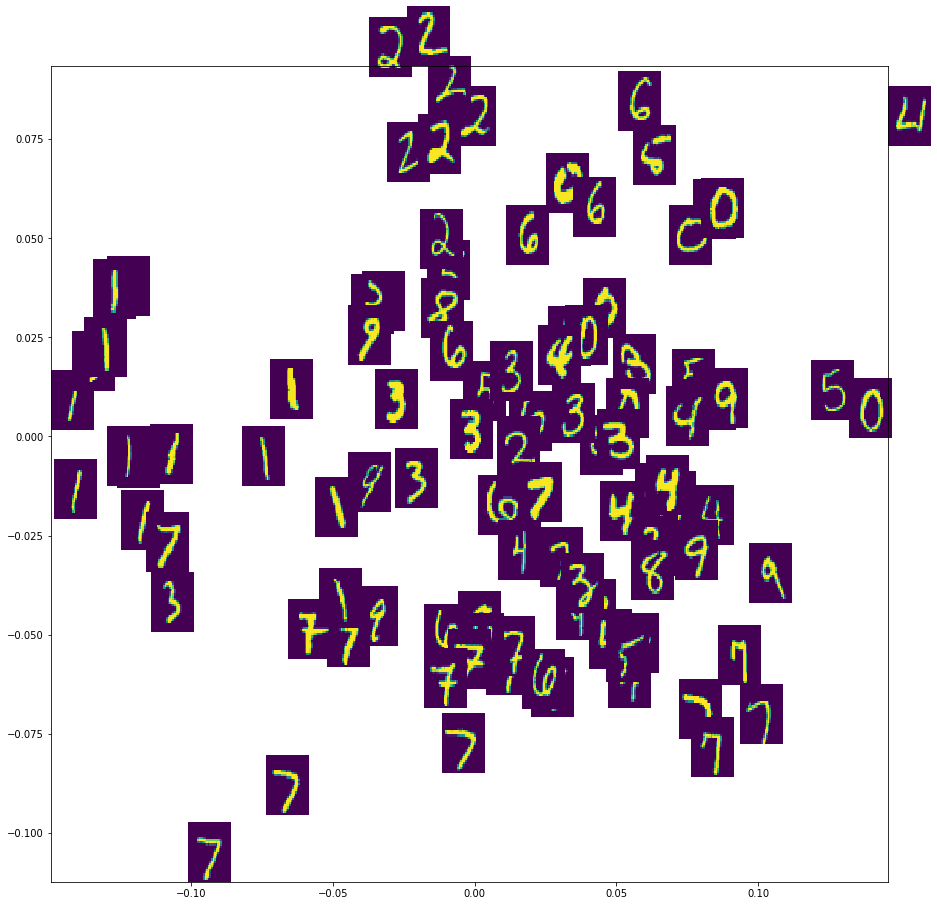

In [37]:
lim = 100

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
xlim = [transformed[:lim,0].min()-10e-10, transformed[:lim,0].max()+10e-10]
ylim = [transformed[:lim,1].min()-10e-10, transformed[:lim,1].max()+10e-10]
i = 0
for (x, y) in zip(transformed[:lim,0],transformed[:lim,1]):
#         img = plt.imread(path)
    bb = Bbox.from_bounds(x, y, 0.015, 0.015)
    bb2 = TransformedBbox(bb, ax.transData)
    bbox_image = BboxImage(bb2, norm=None, origin=None, clip_on=False)
    bbox_image.set_data(X_test[i].reshape(imwidth,imheight))
    ax.add_artist(bbox_image)
    i += 1
ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
plt.savefig('./sup/mnist_scatter.png',bbox_inches='tight')
plt.show()